## Importing the Required Depedencies

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import os

## Set all the constant

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=15

## Loading the Dataset

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "plantvillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [5]:
for image_batch,label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


## Visualize some of the images from our dataset

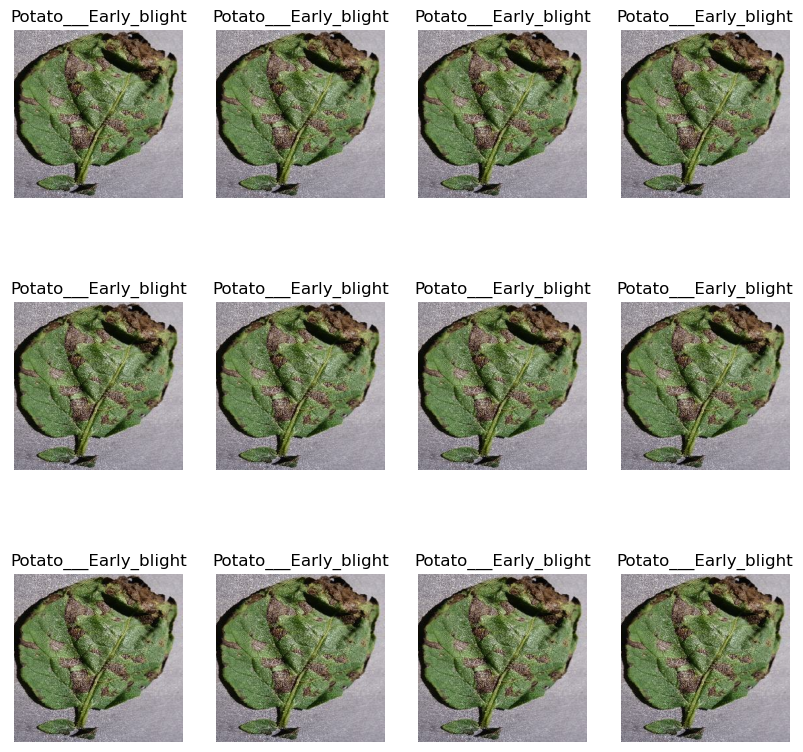

In [6]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
      ax=plt.subplot(3,4,i+1)
      plt.imshow(image_batch[1].numpy().astype('uint8'))
      plt.title(class_names[label_batch[1]])
      plt.axis('off')
    

## Function to Split Dataset
## Dataset should be bifurcated into 3 subsets, namely:

- Training: Dataset to be used while training
- Validation: Dataset to be tested against while training
- Test: Dataset to be tested against after we trained a model

In [7]:
len(dataset)

68

In [8]:
train_size=0.8
len(dataset)*0.8

54.400000000000006

In [9]:
train_ds=dataset.take(54)
len(train_ds)

54

In [10]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [11]:
val_size=0.1
len(dataset)*0.1

6.800000000000001

In [12]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [14]:
def get_dataset_partitions(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
  assert(train_split+val_split+test_split)==1
  ds_size=len(ds)
  if shuffle:
    ds=ds.shuffle(shuffle_size,seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
    

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

In [16]:
len(train_ds),len(val_ds),len(test_ds)

(54, 6, 8)

## Cache, Shuffle, and Prefetch the Dataset

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import RandomContrast, RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

## Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [19]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

Data augmentation techniques include:
- **Random Rotation**: Rotates images by a random degree.
- **Random Flipping**: Flips the images horizontally.
- **Zooming**: Randomly zooms in on the images.

These techniques introduce variability and help the model generalize better.

In [20]:
data_augementation=Sequential([
  RandomContrast(0.1,seed=42,input_shape=(256,256,3)),
  RandomFlip('horizontal',seed=42),
  RandomZoom(0.1,seed=42),
  RandomRotation(0.1)
]
)

## Applying data Augmentation

In [21]:
train_ds=train_ds.map(
  lambda x,y:(data_augementation(x,training=True),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the CNN model

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
cnn_model=models.Sequential([
  resize_and_rescale,
  layers.Conv2D(32,kernel_size=(3,3),padding='same',activation='relu',input_shape=input_shape),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(64,activation='relu'),
  layers.Dense(n_classes,activation='softmax')
])
cnn_model.build(input_shape=input_shape)

In [23]:

cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 256, 256, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 128, 128, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 128, 128, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 128, 128, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 64, 64, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 64, 64, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 64, 64, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 32, 32, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (32, 32, 32, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 32, 32, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 16, 16, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (32, 16, 16, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 16, 16, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 8, 8, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (32, 8, 8, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 4096)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 392,579 (1.50 MB)

 Trainable params: 392,579 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

## Compile the Model

In [24]:
cnn_model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop=EarlyStopping(
  patience=15,
  restore_best_weights=True,
  verbose=1
)

In [26]:
cnn_history=cnn_model.fit(
  train_ds,
  epochs=15,
  validation_data=val_ds,
  batch_size=16,
)

Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.4723 - loss: 0.9813 - val_accuracy: 0.7135 - val_loss: 0.8363
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.7713 - loss: 0.5961 - val_accuracy: 0.7708 - val_loss: 0.5454
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8146 - loss: 0.4188 - val_accuracy: 0.8073 - val_loss: 0.4323
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.8794 - loss: 0.2963 - val_accuracy: 0.8750 - val_loss: 0.3267
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.9110 - loss: 0.2273 - val_accuracy: 0.9427 - val_loss: 0.2472
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.9195 - loss: 0.1948 - val_accuracy: 0.8802 - val_loss: 0.3342
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9271 - loss: 0.2205 - val_accuracy: 0.8594 - val_loss: 0.3018
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.8994 - loss: 0.2795 - val_accuracy: 0.9531 - val_loss:

In [27]:
scores=cnn_model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - accuracy: 0.9702 - loss: 0.0904


In [30]:
cnn_history

In [31]:
cnn_history.params

{'verbose': 'auto', 'epochs': 15, 'steps': 54}

In [34]:
cnn_history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

### Plotting the Accuracy and Loss Curves

In [38]:
acc=cnn_history.history['accuracy']
val_acc=cnn_history.history['val_accuracy']

loss=cnn_history.history['loss']
val_loss=cnn_history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation loss')

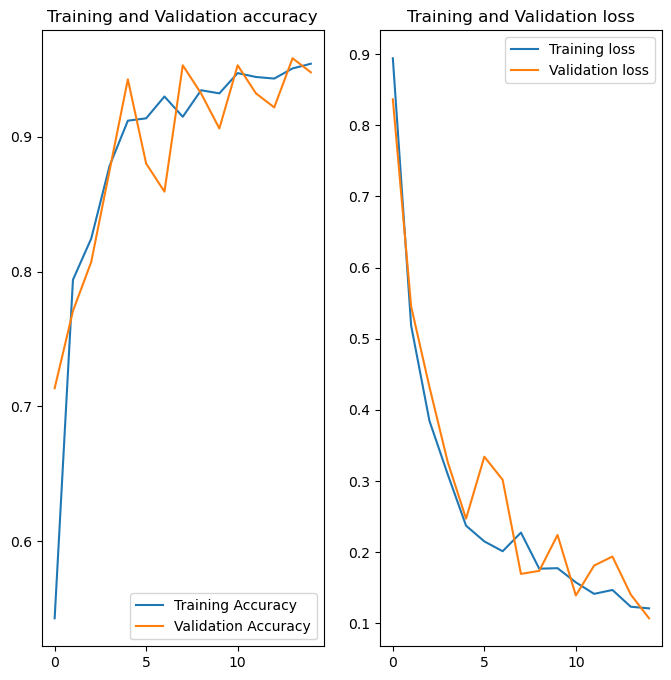

In [42]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(15),acc,label='Training Accuracy')
plt.plot(range(15),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracy')

plt.subplot(1,2,2)
plt.plot(range(15),loss,label='Training loss')
plt.plot(range(15),val_loss,label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')

### Run prediction on a sample image

first image to predict
Actual prediction: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step
predicted label: Potato___Late_blight


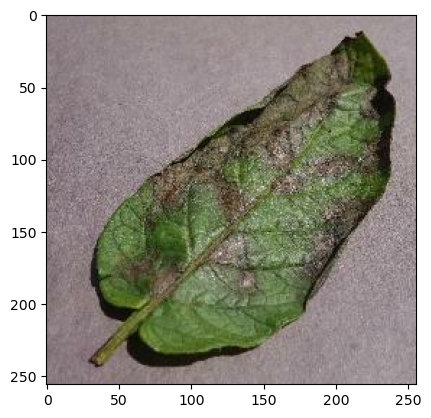

In [48]:
for image_batch,label_batch in test_ds.take(1):
  first_image=image_batch[0].numpy().astype('uint8')
  first_label=label_batch[0].numpy()
  print('first image to predict')
  plt.imshow(first_image)
  print('Actual prediction:',class_names[first_label])
  
  batch_prediction=cnn_model.predict(image_batch)
  print('predicted label:',class_names[np.argmax(batch_prediction[0])])
  

### Write a function for inference

In [49]:
def predict(cnn_model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = cnn_model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


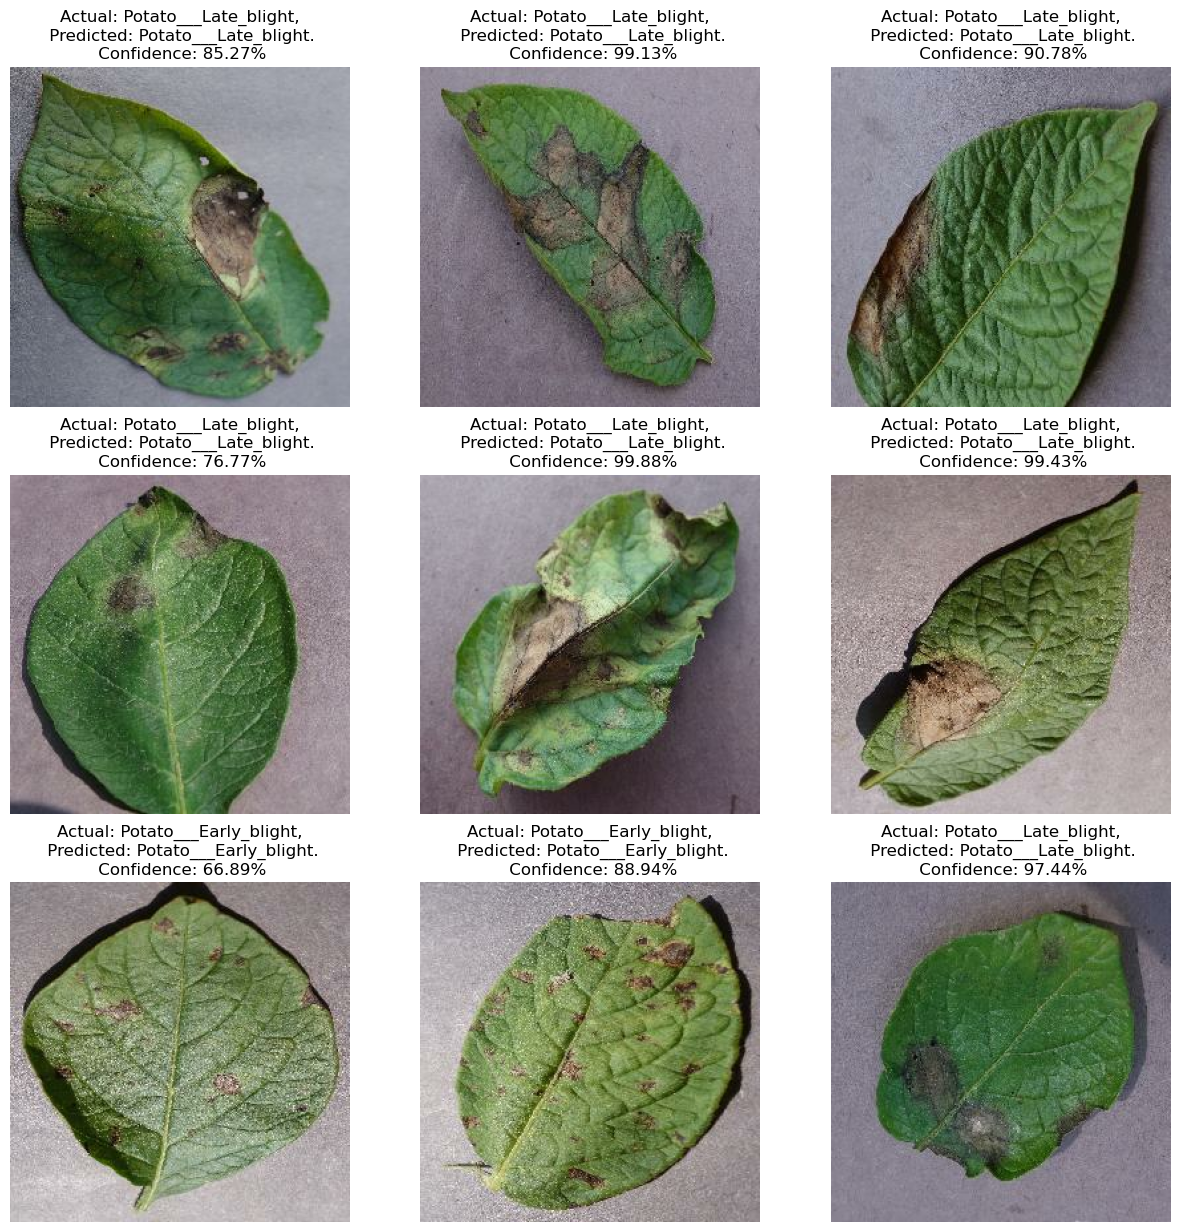

In [50]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(cnn_model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## Saving the Model

In [51]:
cnn_model.save("potatos.h5")